<img style="float: left; margin: 30px 15px 15px 15px;" src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTFzQj91sOlkeDFkg5HDbjtR4QJYmLXkfMNig&usqp=CAU" width="400" height="500" /> 
    
    
### <font color='navy'> Modelos no lineales para pronósticos. 

**Nombres:** Omar Antonio Hernández Sánchez

**Fecha:** 16 de febrero del 2023.

**Expediente** : 733224.
    
**Profesor:** Oscar David Jaramillo Zuluaga.
    
**Link Github**: https://github.com/if720960/Tarea3_LXPerez_OAHernandez_PDCardenas

# Tarea 3: Clase 7

# <font color= Red> Tarea 3

Condensar todos los procedimientos realizados en esta clase donde se implementen los métodos necesarios para crear un correcto flujo de lectura de datos, análisis, ajuste de parámetros, predicción y métricas de errores para un conjunto de datos dado. Algo como lo siguiente:

Implementar los métodos y las lógicas que consideren pertinentes, como de igual forma las posibles variables a introducir en el constructor de la clase.

Posteriormente, utilizar la clase anteriormente creada para generar un modelo SARIMAX para el siguiente conjunto de datos:
https://github.com/quaesito/time-series-forecast-sarimax-prophet/blob/master/A4.xlsx?raw=true### Ejercicio 1: (enunciado) Transcribirlo

Código de solución estudiante 1: Omar

In [1]:
    import pandas as pd
    import numpy as np
    from sklearn.preprocessing import MinMaxScaler, StandardScaler
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
    from statsmodels.tsa.stattools import adfuller
    import matplotlib.pyplot as plt
    from statsmodels.tsa.statespace.sarimax import SARIMAX, SARIMAXResults
    import statsmodels.api as sm
    import statsmodels as st
    import numpy as np
    from statsmodels.tsa.seasonal import MSTL
    import matplotlib.pyplot as plt
    import itertools
    from sklearn.preprocessing import power_transform
    from scipy.stats import normaltest
    from sklearn.model_selection import train_test_split


In [2]:
# Código de solución estudiante 1
class LinearForecast:

    
    def __init__(self, timeseries):
        self.timeseries = timeseries
        
        
    def load_data(self, url:str)-> pd.DataFrame:
        timeseries = pd.read_excel(url)
        #timeseries = timeseries[['date', y]]
        timeseries.set_index('date')
        return timeseries
    
    
    def timeseries_transformation(self, y, kind = 'log'):
        self.timeseries.hist()
        if kind == 'log':    
            self.timeseries[y] = np.log(self.timeseries[y])
        if kind == 'sqrt':
            self.timeseries[y] = np.sqrt(self.timeseries[y])
        if kind == 'box-cox':
            vals_bc = power_transform(self.timeseries[y].to_numpy().reshape(-1, 1), method='box-cox')
            self.timeseries[y] = vals_bc.squeeze()
        if kind == 'yeo-johnson':
            vals_yj = power_transform(self.timeseries[y].to_numpy().reshape(-1, 1), method='yeo-johnson')
            self.timeseries[y] = vals_yj.squeeze()
        if kind == 'mm_scaler':
            mm_scaler = MinMaxScaler()
            vals_mm = mm_scaler.fit_transform(self.timeseries[y].to_numpy().reshape(-1, 1))
            self.timeseries[y] = vals_mm.squeeze()
        if kind == 'scaler':
            scaler = StandardScaler()
            vals_ss = scaler.fit_transform(self.timeseries[y].values.reshape(-1, 1))
            self.timeseries[y] = vals_ss.squeeze()
            
        return self.timeseries  
        
        
        
    def decomposition(self , periods_seasonality = (6,12) , 
                      stl_kwargs = None):
        data1 = self.timeseries.copy()
        model = MSTL(data1, periods = periods_seasonality, stl_kwargs = stl_kwargs)
        res2 = model.fit()
        return res2
    
    
    
    
    def plot_timeseries(self, periods_seasonality):
        res2 = LinearForecast.decomposition(self, periods_seasonality = (6,12))
        
        # Gráfica de descomposición
        fig, ax = plt.subplots(5, 1, sharex=True, figsize=(8, 8))

        res2.observed.plot(ax=ax[0])
        ax[0].set_ylabel('Observed')

        res2.trend.plot(ax=ax[1])
        ax[1].set_ylabel('Trend')

        res2.seasonal[f'seasonal_{periods_seasonality[0]}'].plot(ax=ax[2])
        ax[2].set_ylabel(f'seasonal_{periods_seasonality[0]}')

        res2.seasonal[f'seasonal_{periods_seasonality[1]}'].plot(ax=ax[3])
        ax[3].set_ylabel(f'seasonal_{periods_seasonality[1]}')

        res2.resid.plot(ax=ax[4])
        ax[4].set_ylabel('Residual')

        fig.tight_layout()
        return res2
        
        
        
    def adf_test(self,timeseries):
        print("Results of Dickey-Fuller Test:")
        dftest = adfuller(timeseries, autolag="AIC")
        dfoutput = pd.Series(
            dftest[0:4],
            index=[
                "Test Statistic",
                "p-value",
                "#Lags Used",
                "Number of Observations Used",
            ],
        )
        for key, value in dftest[4].items():
            dfoutput["Critical Value (%s)" % key] = value
        print(dfoutput)
        
        stationary = (dftest[1] <= 0.05) & (dftest[4]['5%'] > dftest[0])
    
        if stationary:
            print("\u001b[32mStationary\u001b[0m")
        else:
            print("\x1b[31mNon-stationary\x1b[0m")
        return stationary

    def plot_acf_pac(self,  kwargs=dict()):
        f = plt.figure(figsize=(8,5))

        ax1 = f.add_subplot(121)

        plot_acf(self.timeseries, zero=False, ax=ax1, **kwargs)

        ax2 = f.add_subplot(122)
        plot_pacf(self.timeseries, zero=False, ax=ax2, method='ols', **kwargs)

        plt.show()
        
        
    def split_train_test(self, train_size = 0.7):
        train, test = train_test_split(self.timeseries,
                                        train_size = train_size,
                                        shuffle = False)
        return train, test
        
    def generate_parameters(self, p,d,q,P,D,Q):
        p = [p for c in range(p)]
        d = [d for c in range (d)]
        q = [q for q in range(q)]
        P = [P for P in range(P)]
        D = [D for D in range(D)]
        Q = [Q for Q in range(Q)]
        t = ['n', 'c', 't', 'ct']
        
        param_no_estacionales = list(itertools.product(p, d, q))
        param_estacionales = [(x[0], x[1], x[2], 12 ) for x in list(itertools.product(P, D, Q))]
        sarimax_params = list(itertools.product(param_no_estacionales, param_estacionales, t))
        return sarimax_params
    
    
    def search_optimal_params(self, sarimax_params):
        # encuentre el 'conjunto más adecuado' de parámetros no estacionales y estacionales
        n = 5
        resultados = pd.DataFrame(columns=['params', 'AIC', 'BIC', 'LLF'],
                                  index=np.arange(0, len(sarimax_params)))

        i = 0
        for par_no_esta, par_esta, trend in sarimax_params:
            mod = SARIMAX(
                endog=self.timeseries,
                trend=trend,
                order=par_no_esta,
                seasonal_order=par_esta
            )
            results = mod.fit(disp=False)

            resultados.loc[i, 'params'] = (par_no_esta, par_esta, trend)
            resultados.loc[i, 'AIC'] = results.aic
            resultados.loc[i, 'BIC'] = results.bic
            resultados.loc[i, 'LLF'] = results.llf
            i += 1
        return resultados
    
    def model_with_optimal_params(self, optimal_params):
        model = SARIMAX(
            endog = self.timeseries,
            trend = optimal_params[2],
            order = optimal_params[0],
            seasonal_order = optimal_params[1],
            enforce_stationary = True,
            enforce_invertibility = False
        )
        
        results = model.fit()
        #results = SARIMAXResults(model)
        return results




In [3]:
# load data
timeseries = pd.read_excel('A4.xlsx')
timeseries = timeseries.drop(['Unnamed: 0' , 'GHI (W/m2)', 'DNI (W/m2)', ' DHI (W/m2)',
                 'Wet bulb temp (C)', 'Dew point temp (C)',
                              'year', 'hour'], axis = 1).set_index('date')
timeseries = timeseries.resample('M').mean()

C:\Users\omara\AppData\Local\Temp\ipykernel_48444\1950634073.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  timeseries = timeseries.resample('M').mean()


In [4]:
timeseries

Energy (kWh)
date                    
1990-01-31    451.887005
1990-02-28    423.897505
1990-03-31    430.298776
1990-04-30    296.197605
1990-05-31    288.352006
...                  ...
2014-08-31    367.172808
2014-09-30    386.856567
2014-10-31    381.547674
2014-11-30    398.744335
2014-12-31    442.269996

[300 rows x 1 columns]

<AxesSubplot: xlabel='date'>

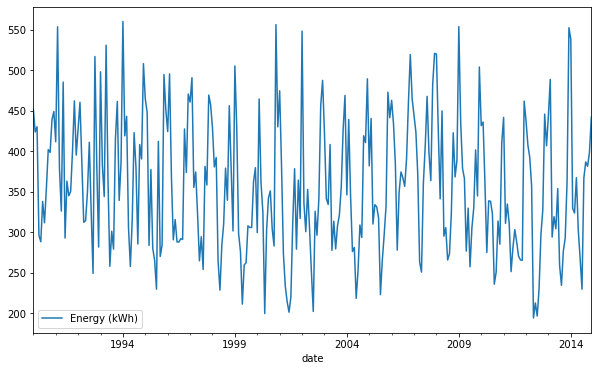

In [5]:
timeseries.plot(figsize = (10,6))

In [6]:
# Inicializar objeto
ts_analyzer = LinearForecast(timeseries)

Energy (kWh)
date                    
1990-01-31      6.113432
1990-02-28      6.049492
1990-03-31      6.064480
1990-04-30      5.691027
1990-05-31      5.664182
...                  ...
2014-08-31      5.905833
2014-09-30      5.958054
2014-10-31      5.944236
2014-11-30      5.988320
2014-12-31      6.091921

[300 rows x 1 columns]

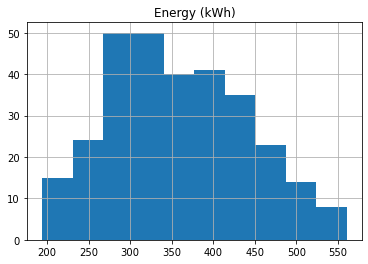

In [7]:
ts_analyzer.timeseries_transformation('Energy (kWh)')

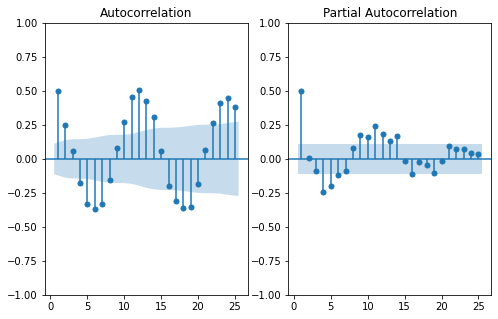

In [8]:
ts_analyzer.plot_acf_pac()

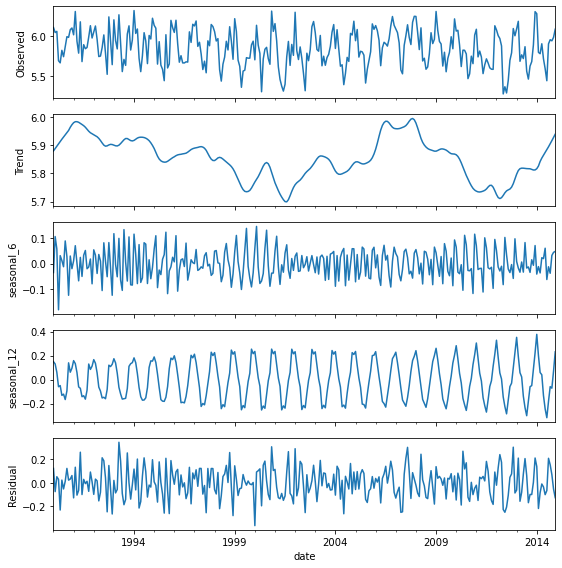

In [9]:
res2 = ts_analyzer.plot_timeseries((6,12))

### Observaciones iniciales

Del plot de la serie de tiempo podemos observar que  es una serie de tiempo con estacionalidad y tendencia, aunque su varianza está muy estabilizada. Tras aplicarle una transformación logarítmica, la gráfica se vuelve normal.

Las primeras gráficas de autocorrelación y autocorrelación parcial muestran que hay una estacionalidad de 6 meses y de 12 meses, por lo que descomponemos en 6 y 12 meses.




In [10]:
train, test = ts_analyzer.split_train_test()

In [11]:
ts_analyzer.adf_test(train)

Results of Dickey-Fuller Test:
Test Statistic                  -1.982817
p-value                          0.294158
#Lags Used                      12.000000
Number of Observations Used    197.000000
Critical Value (1%)             -3.463987
Critical Value (5%)             -2.876326
Critical Value (10%)            -2.574652
dtype: float64
Non-stationary


False

Nuestra serie no es estacionaria. Por lo que intentaremos diferenciar.

In [12]:
# Resultados con una diferenciación
ts_analyzer.adf_test(train.diff().dropna())

Results of Dickey-Fuller Test:
Test Statistic                -8.926989e+00
p-value                        1.005079e-14
#Lags Used                     1.200000e+01
Number of Observations Used    1.960000e+02
Critical Value (1%)           -3.464161e+00
Critical Value (5%)           -2.876402e+00
Critical Value (10%)          -2.574692e+00
dtype: float64
Stationary


True

In [13]:
train = train.diff().dropna()
train

Energy (kWh)
date                    
1990-02-28     -0.063940
1990-03-31      0.014988
1990-04-30     -0.373453
1990-05-31     -0.026845
1990-06-30      0.158986
...                  ...
2007-02-28     -0.047787
2007-03-31     -0.131317
2007-04-30     -0.344261
2007-05-31     -0.048461
2007-06-30      0.362940

[209 rows x 1 columns]

In [14]:
train_analizer = LinearForecast(train)

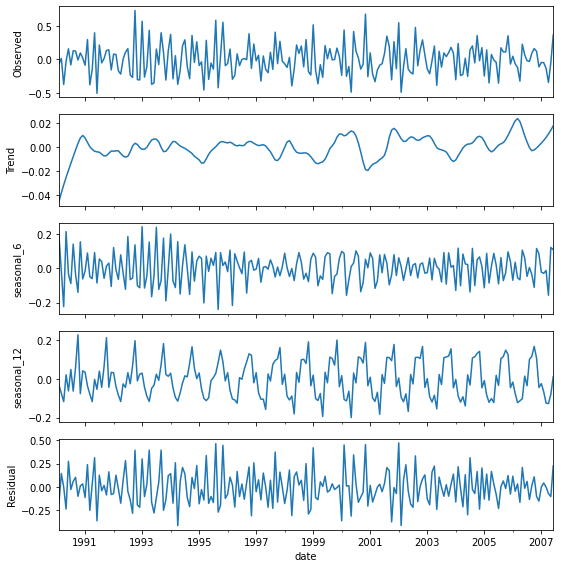

In [15]:
res3 = train_analizer.plot_timeseries((6,12))

In [16]:
non_seasonal = res3.observed - res3.seasonal['seasonal_6'] - res3.seasonal['seasonal_12']

In [17]:
train_analizer.adf_test(non_seasonal)

Results of Dickey-Fuller Test:
Test Statistic                -6.685066e+00
p-value                        4.246461e-09
#Lags Used                     1.500000e+01
Number of Observations Used    1.930000e+02
Critical Value (1%)           -3.464694e+00
Critical Value (5%)           -2.876635e+00
Critical Value (10%)          -2.574816e+00
dtype: float64
Stationary


True

La parte no estacional es estacionaria. Por lo que podemos elegir ya los parámetros de la parte no estaiconal

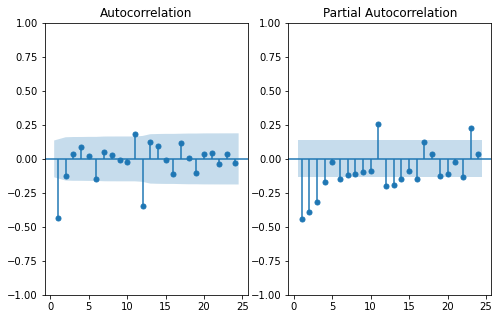

In [18]:
non_seasonal_analizer = LinearForecast(non_seasonal)
non_seasonal_analizer.plot_acf_pac()

Los valores propuestos de p son 1,2,3; el de q, 1 ;y se diferenció 1 vez

Por lo que obtenemos los vectores
* p = [1,2,3],
* d = [1],
* q = [1]

## Parte estacional del modelo

In [19]:
seasonal_segment = res3.seasonal['seasonal_12']
seasonal_analysis = LinearForecast(seasonal_segment)
seasonal_analysis.adf_test(seasonal_segment)

Results of Dickey-Fuller Test:
Test Statistic                -7.847374e+00
p-value                        5.721244e-12
#Lags Used                     1.400000e+01
Number of Observations Used    1.940000e+02
Critical Value (1%)           -3.464515e+00
Critical Value (5%)           -2.876556e+00
Critical Value (10%)          -2.574775e+00
dtype: float64
Stationary


True

La parte estacional es estacionaria. por lo que procederemos a elegir los valores de PDQ

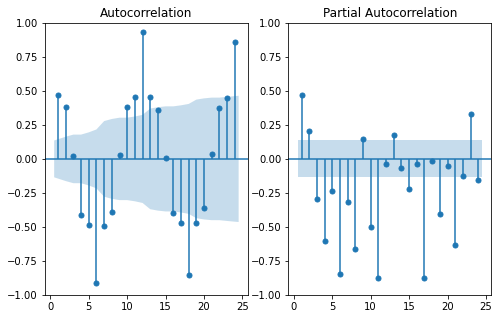

In [20]:
seasonal_analysis.plot_acf_pac()

Proponemos los siguientes valores de PDQ
* P = [1, 2],
* D = [1]
* Q = [1]

In [22]:
sarimax_params = ts_analyzer.generate_parameters(3,1,1,2,1,1)

results_dataframe = train_analizer.search_optimal_params(sarimax_params)
results_dataframe

params        AIC        BIC        LLF
0    ((3, 1, 0), (0, 0, 0, 12), n)  40.278146  53.628299 -16.139073
1    ((3, 1, 0), (0, 0, 0, 12), c)  42.269153  58.956844 -16.134577
2    ((3, 1, 0), (0, 0, 0, 12), t)  42.286952  58.974642 -16.143476
3   ((3, 1, 0), (0, 0, 0, 12), ct)   44.26077  64.285998 -16.130385
4    ((3, 1, 0), (1, 0, 0, 12), n)  33.951548  50.639238 -11.975774
5    ((3, 1, 0), (1, 0, 0, 12), c)  35.943929  55.969158 -11.971965
6    ((3, 1, 0), (1, 0, 0, 12), t)  42.465287  62.490515 -15.232643
7   ((3, 1, 0), (1, 0, 0, 12), ct)  44.438307  67.801073 -15.219153
8    ((3, 1, 0), (0, 0, 0, 12), n)  40.278146  53.628299 -16.139073
9    ((3, 1, 0), (0, 0, 0, 12), c)  42.269153  58.956844 -16.134577
10   ((3, 1, 0), (0, 0, 0, 12), t)  42.286952  58.974642 -16.143476
11  ((3, 1, 0), (0, 0, 0, 12), ct)   44.26077  64.285998 -16.130385
12   ((3, 1, 0), (1, 0, 0, 12), n)  33.951548  50.639238 -11.975774
13   ((3, 1, 0), (1, 0, 0, 12), c)  35.943929  55.969158 -11.971965
14   ((3, 1, 0), (1, 0, 0, 12), t)  42.465287  62.490515 -15.232643
15  ((3, 1, 0), (1, 0, 0, 12), ct)  44.438307  67.801073 -15.219153
16   ((3, 1, 0), (0, 0, 0, 12), n)  40.278146  53.628299 -16.139073
17   ((3, 1, 0), (0, 0, 0, 12), c)  42.269153  58.956844 -16.134577
18   ((3, 1, 0), (0, 0, 0, 12), t)  42.286952  58.974642 -16.143476
19  ((3, 1, 0), (0, 0, 0, 12), ct)   44.26077  64.285998 -16.130385
20   ((3, 1, 0), (1, 0, 0, 12), n)  33.951548  50.639238 -11.975774
21   ((3, 1, 0), (1, 0, 0, 12), c)  35.943929  55.969158 -11.971965
22   ((3, 1, 0), (1, 0, 0, 12), t)  42.465287  62.490515 -15.232643
23  ((3, 1, 0), (1, 0, 0, 12), ct)  44.438307  67.801073 -15.219153

In [24]:
optimal_params = results_dataframe.iloc[1]['params']
optimal_params[0]

(3, 1, 0)

In [45]:
results = train_analizer.model_with_optimal_params(optimal_params)

In [59]:
prediction = results.predict()

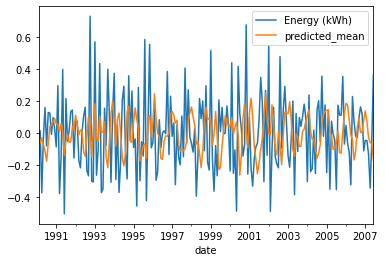

In [60]:
fig, ax = plt.subplots()
train.plot(ax = ax)
prediction.plot(ax = ax)
plt.legend()




Código de solución estudiante 2

In [ ]:
# Código de solución estudiante 2
.
.
.
.


### Respuesta planteada en el ejercicio usando (markdown)
 La respuesta es .........